# Generative Adversarial Networks (GAN)

In this notebook, we will go through basics of GAN and implement wgan on different dataset other than MNIST. We will use pokemon dataset.

**Issue**: *Model keeps breaking ... for both wgan ... Mode collapse* 

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/gan/2019/04/13/Power-of-GAN/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/GAN/gan_pytorch.ipynb)


### Get Data

In [0]:
import os
from pathlib import Path
os.mkdir('data')
os.mkdir('images')

path = Path('data')

In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d dollarakshay/pokemon-images -p {path}

In [0]:
!unzip {path}/'pokemon-images.zip' -d {path}

In [0]:
!unzip {path}/'POKEMON.zip' -d {path}

In [0]:
!ls -lR /content/data/POKEMON/*.png | wc -l #number of train images

## EDA

In [0]:
path = Path('data/POKEMON')

In [0]:
import matplotlib.pyplot as plt
import random
import imageio
%matplotlib inline

def show_images(img_path, path, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(path/img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(f'Image size: {img.shape}')
        plt.axis('off')

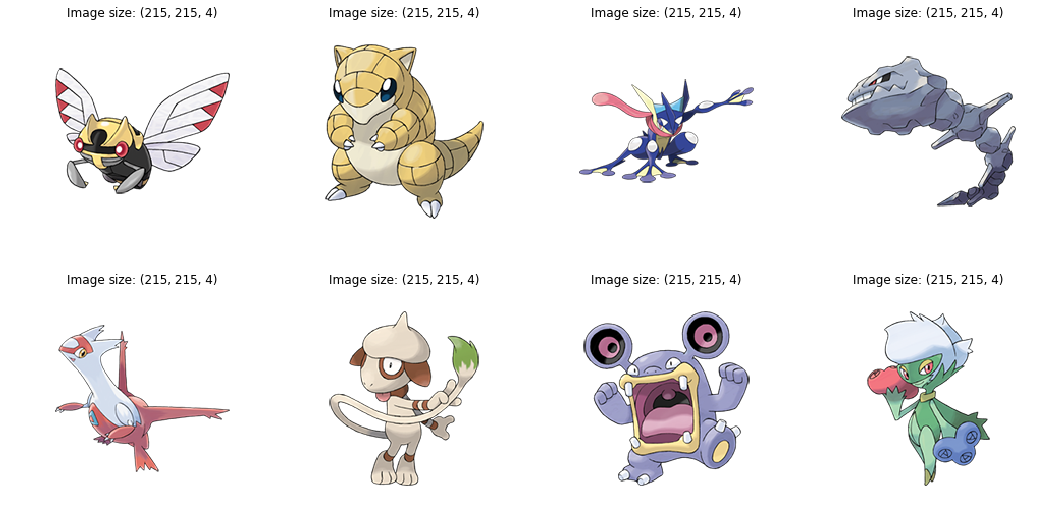

In [0]:
# no, I don't know their names :(
rnd_images = random.sample(os.listdir(f'{path}'), 8)
show_images(rnd_images, path)

# PyTorch

Code Credits : [eriklindernoren](https://github.com/eriklindernoren/PyTorch-GAN)

In [0]:
import numpy as np
import random
import time
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

import matplotlib.pyplot as plt
%matplotlib inline

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Training on %s ...'%format(device))

# Set random seem for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Training on cuda:0 ...
Random Seed:  999


## Vanilla GAN

In [0]:
# load mnist data
batch_size = 1024

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# create data loader and download mnist dataset
train_data = datasets.MNIST('data', train=True,
                            download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

In [0]:
# generator
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.img_shape = (28, 28, 1)
        self.latent_dim = 100

        self.generator = torch.nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, 0.8),         
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, 0.8),
            nn.Linear(1024, np.prod(self.img_shape)),
            nn.Tanh()
        )
        
    def forward(self, x):
        
        # 2 conv layer, with relu activation function
        img = self.generator(x)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [0]:
# Initialize generator
generator = Generator().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
# discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.img_shape = (28, 28, 1)
        
        self.discriminator = torch.nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        
        img = img.view(img.size(0), -1)
        real_fake = self.discriminator(img)
        return real_fake


In [0]:
# Initialize discriminator
discriminator = Discriminator().to(device)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_loss = nn.BCELoss()

In [0]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
latent_dim = 100

In [0]:
def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        noise = torch.from_numpy(noise).to(device) 
        noise = noise.type(Tensor)
        gen_imgs = generator(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5  
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0].cpu().detach().numpy() , cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

In [0]:
def train(epochs, batch_size, show_image_interval, print_every):
    
    for epoch in range(epochs):
        start = time.time()
        
        for i, (imgs, _) in enumerate(train_loader):
            
            # create real and fake labels
            real = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
            
            # configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = discriminator_loss(discriminator(gen_imgs), real)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = discriminator_loss(discriminator(real_imgs), real)
            fake_loss = discriminator_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = 0.5 * (real_loss + fake_loss)

            d_loss.backward()
            optimizer_D.step()

            batches_done = epoch * len(train_loader) + i

        if epoch % print_every == 0:
            
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Time : %.2f sec]" 
                  % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item(), time.time()-start))

        if epoch % show_image_interval == 0:
            sample_images(epoch)              

[Epoch 0/1000] [Batch 58/59] [D loss: 0.336663] [G loss: 0.816553] [Time : 11.69 sec]


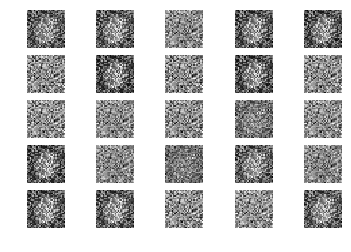

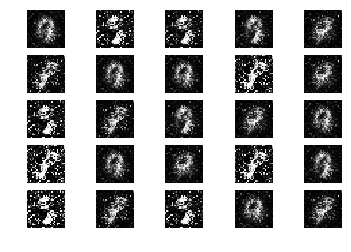

[Epoch 20/1000] [Batch 58/59] [D loss: 0.456184] [G loss: 3.436588] [Time : 11.76 sec]


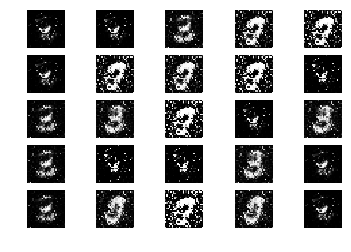

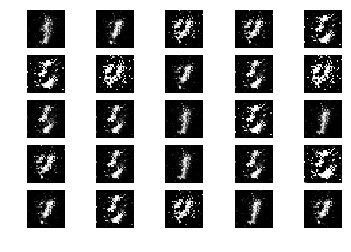

[Epoch 40/1000] [Batch 58/59] [D loss: 0.098369] [G loss: 2.512925] [Time : 7.13 sec]


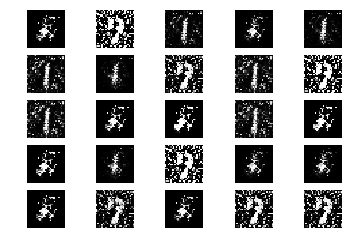

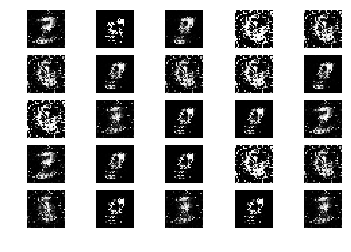

[Epoch 60/1000] [Batch 58/59] [D loss: 0.090052] [G loss: 4.091017] [Time : 7.05 sec]


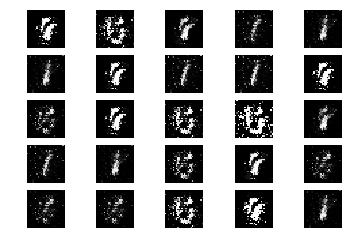

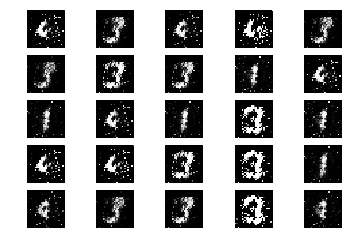

[Epoch 80/1000] [Batch 58/59] [D loss: 0.351541] [G loss: 4.190561] [Time : 11.51 sec]


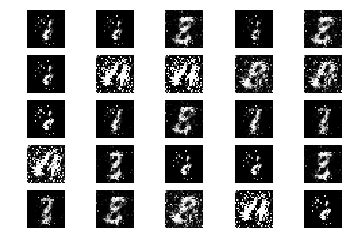

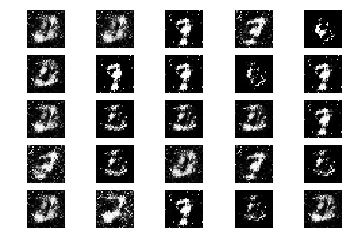

[Epoch 100/1000] [Batch 58/59] [D loss: 0.242418] [G loss: 1.773041] [Time : 11.09 sec]


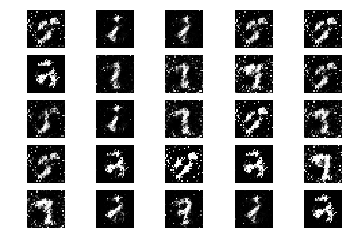

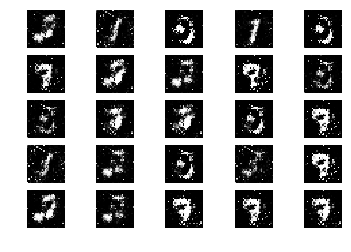

[Epoch 120/1000] [Batch 58/59] [D loss: 0.311521] [G loss: 1.050602] [Time : 11.06 sec]


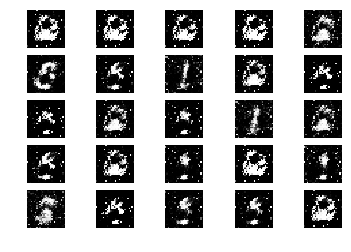

KeyboardInterrupt: ignored

In [0]:
train(epochs=1000, batch_size=batch_size, show_image_interval=10, print_every=20)

## WGAN

In [0]:
# load mnist data
batch_size = 256

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# create data loader and download mnist dataset
train_data = datasets.MNIST('data', train=True,
                            download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

In [0]:
# generator
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.img_shape = (28, 28, 1)
        self.latent_dim = 100

        self.generator = torch.nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512, 0.8),         
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024, 0.8),
            nn.Linear(1024, np.prod(self.img_shape)),
            nn.Tanh()
        )
        
    def forward(self, x):
        
        # 2 conv layer, with relu activation function
        img = self.generator(x)
        img = img.view(img.size(0), *self.img_shape)
        return img

In [0]:
# Initialize generator
generator = Generator().to(device)
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=0.0002)

In [0]:
# discriminator
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.img_shape = (28, 28, 1)
        
        self.discriminator = torch.nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
        
    def forward(self, img):
        
        img = img.view(img.size(0), -1)
        real_fake = self.discriminator(img)
        return real_fake


In [0]:
# Initialize discriminator
discriminator = Discriminator().to(device)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=0.0002)

In [0]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
latent_dim = 100
n_critic = 5
clip_value = 0.01

In [0]:
def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        noise = torch.from_numpy(noise).to(device) 
        noise = noise.type(Tensor)
        gen_imgs = generator(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5  
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0].cpu().detach().numpy() , cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

In [0]:
def train(epochs, batch_size, show_image_interval, print_every):
    
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(train_loader):
            
            # configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z).detach()
            # Adversarial loss
            d_loss = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

            d_loss.backward()
            optimizer_D.step()

            # Clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            # Train the generator every n_critic iterations
            if i % n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                optimizer_G.zero_grad()

                # Generate a batch of images
                gen_imgs = generator(z)
                # Adversarial loss
                g_loss = -torch.mean(discriminator(gen_imgs))

                g_loss.backward()
                optimizer_G.step()

            batches_done = epoch * len(train_loader) + i

        if epoch % print_every == 0:
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" 
                  % (epoch, epochs, i, len(train_loader), d_loss.item(), g_loss.item()))

        if epoch % show_image_interval == 0:
            sample_images(epoch)              

[Epoch 0/1000] [Batch 234/235] [D loss: -1.232288] [G loss: -18.501410]


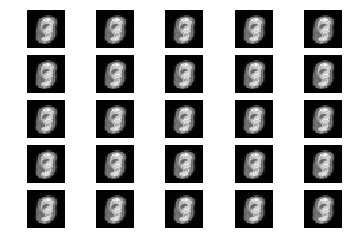

[Epoch 10/1000] [Batch 234/235] [D loss: -0.324680] [G loss: -5.044616]
[Epoch 20/1000] [Batch 234/235] [D loss: -0.745363] [G loss: 0.019583]


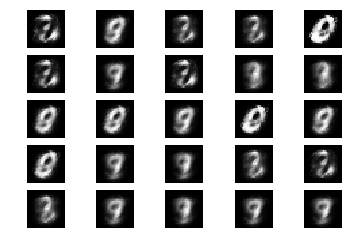

[Epoch 30/1000] [Batch 234/235] [D loss: -1.060575] [G loss: 0.150953]
[Epoch 40/1000] [Batch 234/235] [D loss: -0.850163] [G loss: -1.066685]


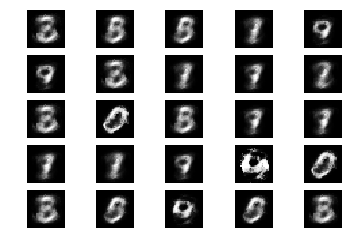

[Epoch 50/1000] [Batch 234/235] [D loss: -1.138303] [G loss: 1.019417]
[Epoch 60/1000] [Batch 234/235] [D loss: -0.970629] [G loss: -1.267066]


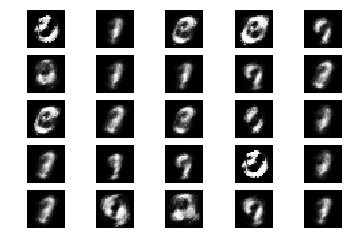

[Epoch 70/1000] [Batch 234/235] [D loss: -0.731661] [G loss: -0.221044]
[Epoch 80/1000] [Batch 234/235] [D loss: -0.657645] [G loss: -0.629048]


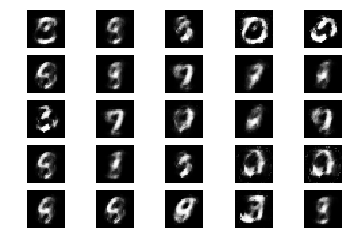

[Epoch 90/1000] [Batch 234/235] [D loss: -0.584315] [G loss: -0.462371]
[Epoch 100/1000] [Batch 234/235] [D loss: -0.568697] [G loss: -0.675995]


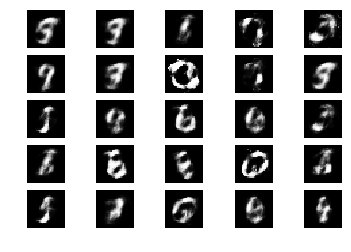

[Epoch 110/1000] [Batch 234/235] [D loss: -0.496589] [G loss: -0.248923]
[Epoch 120/1000] [Batch 234/235] [D loss: -0.559259] [G loss: -0.161993]


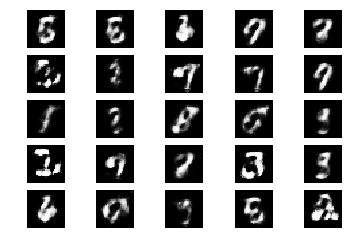

[Epoch 130/1000] [Batch 234/235] [D loss: -0.512239] [G loss: -0.403667]
[Epoch 140/1000] [Batch 234/235] [D loss: -0.456642] [G loss: -0.981317]


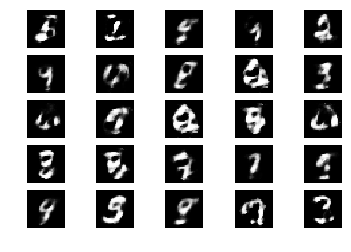

[Epoch 150/1000] [Batch 234/235] [D loss: -0.415741] [G loss: 0.306988]
[Epoch 160/1000] [Batch 234/235] [D loss: -0.492813] [G loss: -0.441706]


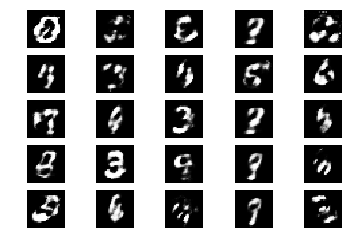

[Epoch 170/1000] [Batch 234/235] [D loss: -0.493724] [G loss: -0.726565]
[Epoch 180/1000] [Batch 234/235] [D loss: -0.473445] [G loss: -0.706335]


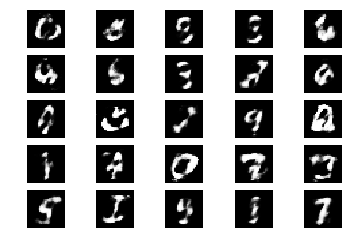

[Epoch 190/1000] [Batch 234/235] [D loss: -0.398683] [G loss: -1.040396]
[Epoch 200/1000] [Batch 234/235] [D loss: -0.372178] [G loss: 0.046159]


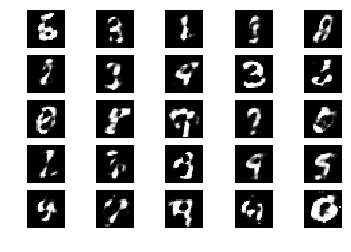

[Epoch 210/1000] [Batch 234/235] [D loss: -0.332121] [G loss: 0.262158]
[Epoch 220/1000] [Batch 234/235] [D loss: -0.327789] [G loss: 0.188430]


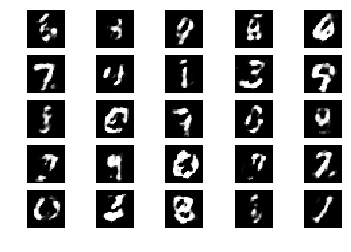

[Epoch 230/1000] [Batch 234/235] [D loss: -0.368951] [G loss: -0.464618]


KeyboardInterrupt: ignored

In [0]:
train(epochs=1000, batch_size=batch_size, show_image_interval=20, print_every=10)